# Assignment 3

In [1]:
import datetime  # datetime module, which provides classes for working with dates and times in Python
import numpy as np
import xarray as xr  # xarray for multi-dimensional data manipulation
import warnings  # provides a way to control warnings issued by Python
import fwi_nz as fwi_calc  # imports a module called "fwi_nz.py" and gives it the alias "fwi_calc"
warnings.filterwarnings('ignore')  # sets the warning filter to ignore all warnings

from dask.diagnostics import ProgressBar
from dateutil import parser
from datetime import timedelta
import envlib_helper as envlib  # imports a module called "envlib_helper.py" and gives it the alias "envlib"
from tethysts import Tethys  # module for time series manipulation

import pandas as pd
import matplotlib.pyplot as plt
import salem  # library for geographical data analysis
import cartopy.crs as ccrs  # alternative way to handle plotting/projection
import glob  # library to handle path/folder/file related issues
from dask.distributed import Client
from functools import partial

# Additional imports for plotting and data manipulation
import dask.array as da
import seaborn as sns
import cartopy.feature as cfeature
import cartopy as cart
import matplotlib.ticker as mticker
import calendar


In [2]:
def UTC_2_NZST(data):
    """
    Converts time values from UTC to NZST (New Zealand Standard Time).
        
    Returns:
        xarray.Dataset or xarray.DataArray: Data with time values converted to NZST.
    """
    
    # Convert time values to pandas datetime objects
    times = pd.to_datetime(data.time.values)
    
    # Convert time values from UTC to NZST
    times_nzt = times.tz_localize("UTC").tz_convert("NZ")
    
    # Convert time values to numpy datetime64 objects with nanosecond precision
    times_nzt_np = np.array(times_nzt.strftime("%Y-%m-%dT%H:%M:%S.%f"), dtype="datetime64[ns]")
    
    # Update the time values in the data with NZST values
    data["time"] = times_nzt_np
    
    return data


## Task 1 

### a. Calculate FWI from Automatic Weather Station (AWS)

#### 1. Load datasets from FENZ and Specify to Motukarara Only

In [3]:
ts = Tethys() # Create a Tethys object
datasets = ts.datasets # Get the datasets from Tethys
envlib.get_all_dataset_information(ts) # Call a function to get all dataset information

method  \
feature    parameter             owner                                          
atmosphere air_ventilation_index NZ Open Modelling Consortium      simulation   
                                 NZ Open Modelling Consortium      simulation   
                                 NZ Open Modelling Consortium      simulation   
                                 NZ Open Modelling Consortium      simulation   
           barometric_pressure   ECMWF                             simulation   
...                                                                       ...   
waterway   velocity              Environment Southland         field_activity   
                                 Hawks Bay Regional Council    field_activity   
                                 Horizons Regional Council     field_activity   
                                 Tasman District Council       field_activity   
           water_use             Environment Southland             simulation   

                                                                                                product_code  \
feature    parameter             owner                                                                         
atmosphere air_ventilation_index NZ Open Modelling Consortium       UC WRF NZ South Island Central Otago 1km   
                                 NZ Open Modelling Consortium    UC WRF NZ South Island North Canterbury 1km   
                                 NZ Open Modelling Consortium  UC WRF NZ South Island Marlborough Nelson 1km   
                                 NZ Open Modelling Consortium                     UC WRF NZ South Island 3km   
           barometric_pressure   ECMWF                                                  reanalysis-era5-land   
...                                                                                                      ...   
waterway   velocity              Environment Southland                               quality_controlled_data   
                                 Hawks Bay Regional Council                          quality_controlled_data   
                                 Horizons Regional Council                           quality_controlled_data   
                                 Tasman District Council                             quality_controlled_data   
           water_use             Environment Southland                             stream depletion method 1   

                                                              aggregation_statistic  \
feature    parameter             owner                                                
atmosphere air_ventilation_index NZ Open Modelling Consortium         instantaneous   
                                 NZ Open Modelling Consortium         instantaneous   
                                 NZ Open Modelling Consortium         instantaneous   
                                 NZ Open Modelling Consortium         instantaneous   
           barometric_pressure   ECMWF                                instantaneous   
...                                                                             ...   
waterway   velocity              Environment Southland                     sporadic   
                                 Hawks Bay Regional Council                sporadic   
                                 Horizons Regional Council                 sporadic   
                                 Tasman District Council                   sporadic   
           water_use             Environment Southland                         mean   

                                                              frequency_interval  \
feature    parameter             owner                                             
atmosphere air_ventilation_index NZ Open Modelling Consortium                  H   
                                 NZ Open Modelling Consortium                  H   
                                 NZ Open Modelling Consortium                  H   
        

In [4]:
#prepare variables for retrieving raw sensor data for a particular location specified by its latitude and longitude coordinates (-43.7254 and 172.5805)
owner = "FENZ"
method = "sensor_recording"
product_code = "raw_data"
lat, lon = -43.7254, 172.5805

In [5]:
%%time
#call function get_data_from_lat_lon() from envlib to get dataset
station_data_UTC = envlib.get_data_from_lat_lon(ts, owner, method, product_code, lat, lon,squeeze_dims=True)
station_data_UTC

CPU times: user 671 ms, sys: 80.9 ms, total: 752 ms
Wall time: 29.5 s


<xarray.Dataset>
Dimensions:                   (time: 198348)
Coordinates:
  * time                      (time) datetime64[ns] 1999-08-13T23:00:00 ... 2...
    geometry                  <U42 '01010000007B14AE47E1926540C7681D554DDC45C0'
    height                    int8 2
Data variables:
    station_id                object '1dd0e5e15552fce719028dbd'
    externalId                object 'CLIDB_39788'
    name                      object 'Motukarara'
    ref                       object 'motukarara'
    wind_direction            (time) float32 nan 67.5 67.5 ... 58.8 56.0 54.9
    lat                       float64 -43.72
    lon                       float64 172.6
    temperature               (time) float32 8.0 8.0 8.1 8.0 ... 18.6 18.9 19.5
    precipitation             (time) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    wind_speed                (time) float32 3.5 4.05 4.45 ... 11.02 11.89 11.45
    relative_humidity         (time) float32 82.5 79.5 83.0 ... 71.2 69.7 65.4
    volumetric_water_content  (time) float32 nan nan nan nan ... 7.0 7.0 7.0 7.0
Attributes:
    result_type:     time_series
    title:           mean wind_direction in deg of the atmosphere by a sensor...
    institution:     FENZ
    license:         https://creativecommons.org/licenses/by/4.0/
    source:          sensor_recording
    system_version:  4
    version_date:    2022-03-23T00:00:00

In [6]:
#convert the time of the data from UTC to NZST by calling UTC_2_NZST() function
station_data_NZST = UTC_2_NZST(station_data_UTC)
station_data_NZST

<xarray.Dataset>
Dimensions:                   (time: 198348)
Coordinates:
  * time                      (time) datetime64[ns] 1999-08-14T11:00:00 ... 2...
    geometry                  <U42 '01010000007B14AE47E1926540C7681D554DDC45C0'
    height                    int8 2
Data variables:
    station_id                object '1dd0e5e15552fce719028dbd'
    externalId                object 'CLIDB_39788'
    name                      object 'Motukarara'
    ref                       object 'motukarara'
    wind_direction            (time) float32 nan 67.5 67.5 ... 58.8 56.0 54.9
    lat                       float64 -43.72
    lon                       float64 172.6
    temperature               (time) float32 8.0 8.0 8.1 8.0 ... 18.6 18.9 19.5
    precipitation             (time) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    wind_speed                (time) float32 3.5 4.05 4.45 ... 11.02 11.89 11.45
    relative_humidity         (time) float32 82.5 79.5 83.0 ... 71.2 69.7 65.4
    volumetric_water_content  (time) float32 nan nan nan nan ... 7.0 7.0 7.0 7.0
Attributes:
    result_type:     time_series
    title:           mean wind_direction in deg of the atmosphere by a sensor...
    institution:     FENZ
    license:         https://creativecommons.org/licenses/by/4.0/
    source:          sensor_recording
    system_version:  4
    version_date:    2022-03-23T00:00:00

In [7]:
#select the data from 2016-12-01 to 2017-03-01
station_data_NZST_selected = station_data_NZST.sel(time=slice("2016-12-01","2017-03-01"))

#### 2. Design a function for calculating FWI

In [8]:
def cal_FWI_AWS(station_data, start_date):
    """
    Calculates the Fire Weather Index (FWI) using Automatic Weather Station (AWS) data.
        
    Returns:
        xarray.DataArray: FWI data calculated from the AWS data.
    """
    
    # Find the first non-zero precipitation value on or before the start date
    while station_data.sel(time=start_date)["precipitation"].sum().values != 0:
        start_date = parser.parse(start_date).date()
        start_date = start_date - timedelta(days=1)
        start_date = start_date.strftime("%Y-%m-%d")
    
    # Set the end date for FWI calculation
    end_date = "2017-02-13"
    
    # Perform FWI calculation using the FWI_combined_calc() function from the fwi_calc module
    ffmc_data, dmc_data, dc_data, isi_data, bui_data, fwi_data = fwi_calc.FWI_combined_calc(
        station_data.temperature,
        station_data.relative_humidity,
        station_data.wind_speed,
        station_data.precipitation,
        start_date=start_date,
        end_date=end_date,
        ws_unit="m/s"
    )
    
    return fwi_data

#### 3. Results for each required period:

In [9]:
%%time
#1 week prior to the first event
fwi_data_1_week_AWS = cal_FWI_AWS(station_data_NZST_selected, "2017-02-06")

#1 month prior to the first event
fwi_data_1_month_AWS = cal_FWI_AWS(station_data_NZST_selected, "2017-01-13")

#2 months prior to the first event
fwi_data_2_months_AWS = cal_FWI_AWS(station_data_NZST_selected, "2016-12-13")

CPU times: user 1.35 s, sys: 72.2 ms, total: 1.42 s
Wall time: 1.43 s


#### 4. Plots for each period:

In [10]:
def plot_week_month_2months(data_1_week, data_1_month, data_2_months):
    # Set the figure size
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the data for one week
    data_1_week.plot(ax=ax, label = "One Week")
    
    # Plot the data for one month on top of the previous plot
    data_1_month.plot(ax=ax, label = "One Month")
    
    # Plot the data for two months on top of the previous plot
    data_2_months.plot(ax=ax, label = "Two Months")
    
    # Set the title and axis labels
    ax.legend()
    ax.set_title('FWI Data')
    ax.set_xlabel('Date')
    ax.set_ylabel('FWI')
    
    # Display the plot
    plt.show()

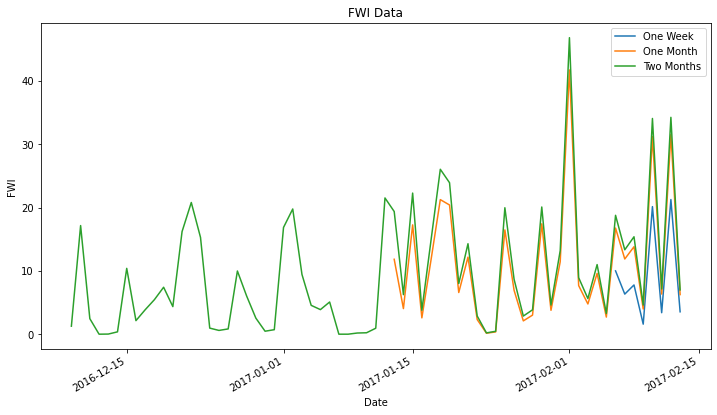

In [11]:
plot_week_month_2months(fwi_data_1_week_AWS, fwi_data_1_month_AWS, fwi_data_2_months_AWS)

### b. Calculate FWI from Meteorological Model Gridded Data from WRF

#### 1. Load Each Weather Data from MetService_WRF & Specify to Motukarara Only

In [12]:
def _preprocess(x, lon, lat):
    """
    Preprocesses a dataset by selecting the nearest lon/lat coordinates.
        
    Returns:
        xarray.Dataset or xarray.DataArray: Preprocessed dataset with lon/lat coordinates selected.
    """
    return x.sel(lon=lon, lat=lat, method="nearest")



def load_file(filetype):
    """
    Loads and preprocesses files of a specific type.
        
    Returns:
        xarray.Dataset: Concatenated and preprocessed dataset containing the loaded files.
    """
    lon, lat = 172.5805, -43.7254
    
    # Create a partial function with _preprocess() and fixed lon/lat values
    partial_func = partial(_preprocess, lon=lon, lat=lat)
    
    # Initialize an empty list to store the loaded files
    empty_list = []
    
    # Load files for the specified timing
    for timing in ["201612", "201701", "201702"]:
        file_path = f"/mnt/data/MetService_WRF/{filetype}_{timing}*"
        
        # Open and preprocess the file using the partial function and parallel processing
        file = xr.open_mfdataset(file_path, preprocess=partial_func, chunks={'time': 200}, parallel=True)
        
        # Append the file to the list
        empty_list.append(file)

    # Concatenate all the files along the 'time' dimension
    files = xr.concat([empty_list[0], empty_list[1], empty_list[2]], dim='time')
    
    # Check if the file contains a 'height' variable
    if 'height' in files.variables:
        # Select the first index value of the 'height' coordinate
        files = files.sel(height=files["height"][0])
        
        # Drop the 'height' variable from the dataset
        files = files.drop("height")
    
    # Reset lat and lon coordinates to variables
    files = files.reset_coords(['lat'])
    files = files.reset_coords(['lon'])
    
    # Convert time from UTC to NZST (New Zealand Standard Time)
    files = UTC_2_NZST(files)
    
    return files

In [13]:
#call load_file() function for each type of file  
ds_rh = load_file("RH")
ds_t = load_file("T") - 273
ds_rain = load_file("RAINNC")
ds_u = load_file("U")
ds_v = load_file("V")

#### 2. Consolidate all Weather Data to One File and Calculate Wind Speed 

In [14]:
#once data for each category is obtained, combine them together to one dataset
da_wrf = ds_rh
da_wrf = da_wrf.rename({"RH": "relative_humidity"})
da_wrf["temperature"] = ds_t["T"]
da_wrf["precipitation"] = ds_rain["RAINNC"]
da_wrf["V"] = ds_v["V"]
da_wrf["U"] = ds_u["U"]

In [15]:
#call wind_speed_from_component() function from fwi_calc file to calculate wind speed 
da_wrf["wind_speed"] = fwi_calc.wind_speed_from_component(da_wrf["U"], da_wrf["V"])

In [16]:
%%time
#compute the above
with ProgressBar():        
    results_WRF = da_wrf.compute()

[########################################] | 100% Completed |  4min 13.3s
CPU times: user 38.5 s, sys: 2min 56s, total: 3min 35s
Wall time: 4min 13s


#### 3. Design a function for calculating FWI 

In [17]:
def cal_FWI_ARF(results_WRF, start_date, end_date = "2017-02-13"):
    
    # Check if precipitation was occurring on the start date. If yes, move one day before (tested on 2017-01-31)
    while results_WRF.sel(time = start_date)["precipitation"].sum().round() != 0:
        start_date = parser.parse(start_date).date()
        start_date = start_date - timedelta(days=1)
        start_date = start_date.strftime("%Y-%m-%d")
    
    # Calculate the components of FWI using the FWI combined calculation function
    ffmc_da, dmc_da, dc_da, isi_da, bui_da, fwi_da = fwi_calc.FWI_combined_calc(
        temperature = results_WRF.temperature,
        rel_hum = results_WRF.relative_humidity,
        wind_speed = results_WRF.wind_speed,
        precipitation = results_WRF.precipitation,
        start_date = start_date,
        end_date = end_date,
        ws_unit = "m/s")
        
    return fwi_da


#### 4. Results for each required period

In [18]:
#1 week prior to the first event
fwi_data_1_week_WRF = cal_FWI_ARF(results_WRF, "2017-02-06")

#1 month prior to the first event
fwi_data_1_month_WRF = cal_FWI_ARF(results_WRF, "2017-01-13")

#2 months prior to the first event
fwi_data_2_months_WRF = cal_FWI_ARF(results_WRF, "2016-12-13")

#### 5. Plots for each period

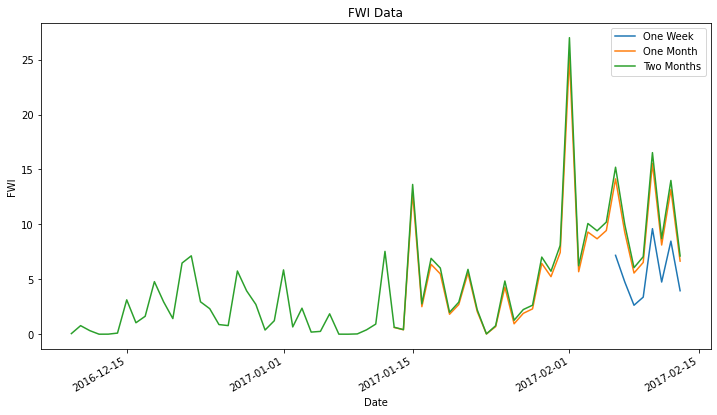

In [19]:
plot_week_month_2months(fwi_data_1_week_WRF, fwi_data_1_month_WRF, fwi_data_2_months_WRF)

### c. FWI Difference between WRF and AWS: 
#### Conclusion:

1. By comparing the plots of FWI data from WRF and AWS for different time periods (one week, one month, two months), we observe that both datasets demonstrate strikingly similar trends. Specifically, when the FWI values recorded by AWS reach their highest or lowest points, corresponding peaks or troughs are also observed in the FWI values obtained from the WRF dataset. 

2. However, there is a noticeable difference in the range of FWI values between the two datasets. AWS FWI shows a wider range, spanning from 0 to 50, while WRF FWI has a narrower range, ranging from 0 to 30. This suggests that the FWI values from AWS may indicate a higher variability and potentially more extreme fire weather conditions compared to the FWI values from the WRF. The differences in range could be attributed to various factors, including data from different heights used in the calculation.

3. In some instances, we observe that the FWI values obtained from AWS are lower than the corresponding values from WRF on the plots (higher variability), specifically on dates such as 2017-02-09 and 2017-02-11.

In [20]:
def plot_2_comparison(data_AWS, data_WRF, length):
    # Set the figure size
    fig, ax = plt.subplots(figsize=(15, 6))
    
    label = length
    
    # Plot the data for one week
    data_AWS.plot(ax=ax, label = label + " AWS")
    
    # Plot the data for one month on top of the previous plot
    data_WRF.plot(ax=ax, label = label + " WRF")
    
    # Set the title and axis labels
    ax.legend()
    ax.set_title('FWI Data ' + length)
    ax.set_xlabel('Date')
    ax.set_ylabel('FWI')
    
    # Display the plot
    plt.show()

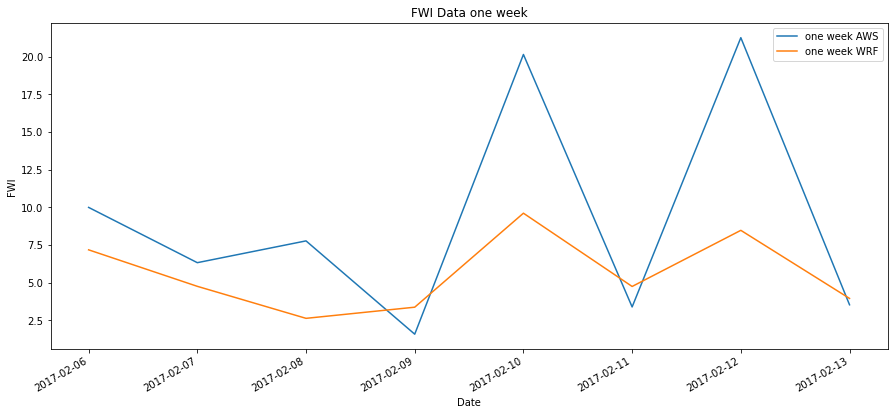

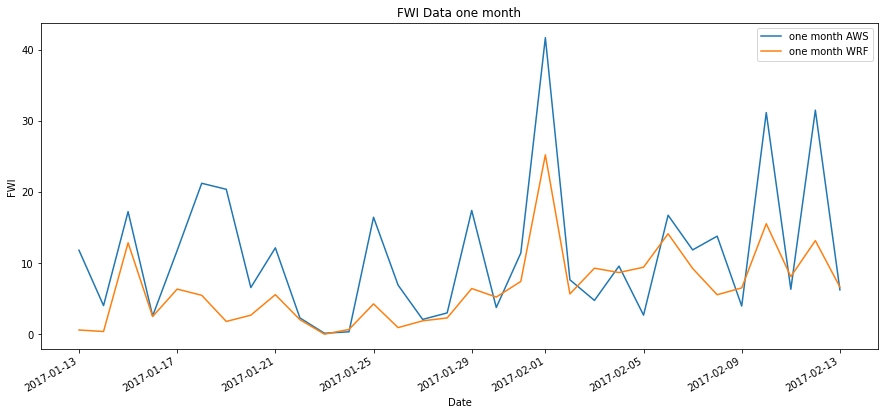

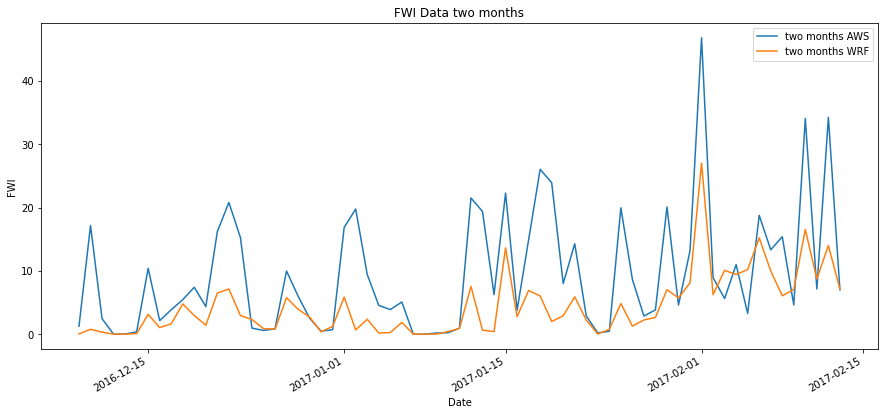

In [21]:
plot_2_comparison(fwi_data_1_week_AWS, fwi_data_1_week_WRF, "one week")
plot_2_comparison(fwi_data_1_month_AWS, fwi_data_1_month_WRF, "one month")
plot_2_comparison(fwi_data_2_months_AWS, fwi_data_2_months_WRF, "two months")

## Task 2 

### a. Explore Regions with Highest Occurence of Extreme Fire Weather Conditions

In [22]:
# Specify the file path for 2016 FWI data
file_path_2016 = f"/mnt/data/FWI_WRF/FWI_2016*"
# Open and load the 2016 FWI data using the specified file path
file_2016 = xr.open_mfdataset(file_path_2016)

# Specify the file path for 2017 FWI data
file_path_2017 = f"/mnt/data/FWI_WRF/FWI_2017*"
# Open and load the 2017 FWI data using the specified file path
file_2017 = xr.open_mfdataset(file_path_2017)

# Concatenate the 2016 and 2017 FWI data along the time dimension in UTC time
files_UTC = xr.concat([file_2016, file_2017], dim='time')

# Convert the dataset from UTC time to NZST (New Zealand Standard Time)
files = UTC_2_NZST(files_UTC)

# Select the data within the specified time range ("2016-09-01" to "2017-04-01") and extract the FWI variable
files = files.sel(time=slice("2016-09-01", "2017-04-01")).FWI

In [23]:
%%time
with ProgressBar():
    fwi_files = files.compute()

[########################################] | 100% Completed | 10.4s
CPU times: user 229 ms, sys: 1.54 s, total: 1.77 s
Wall time: 10.4 s


In [24]:
%%time
# Create a binary mask where FWI values are less than or equal to 31
fwi_binary = fwi_files.where(fwi_files <= 31, 1)
# Set FWI values greater than 31 to 0 in the binary mask
fwi_binary = fwi_binary.where(fwi_files > 31, 0)

# Sum the binary mask over the "time" dimension where the value is 1
fwi_binary_sum = fwi_binary.where(fwi_binary == 1).sum(dim="time")

CPU times: user 263 ms, sys: 147 ms, total: 410 ms
Wall time: 408 ms


In [25]:
def plot_fwi_map(data, cmap="inferno"):
    # Define a projection for the map
    
    # Set up the figure and axes with the specified projection
    map_proj = ccrs.PlateCarree(central_longitude=170)
    ax = plt.axes(projection=map_proj)
    
    # Plot the data using the provided colormap and transform the data to the desired projection
    im = data.plot(ax=ax, transform=data.salem.cartopy(), cmap=cmap)
    
    # Add coastlines to the map
    ax.coastlines()
    
    # Set the aspect ratio of the map to "equal"
    ax.set_aspect('equal')
    
    # Add various features to the map
    ax.add_feature(cfeature.BORDERS, linewidth=0.7, edgecolor='black')
    ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='none', linewidth=0.6)
    
    # Draw spatial gridlines
    gls = ax.gridlines(draw_labels=True, color='black', alpha=0.001)
    # Set the spacing of the gridlines to every 3 degrees of longitude and every 2 degrees of latitude
    gls.xlocator = plt.FixedLocator(range(-180, 181, 3))
    gls.ylocator = plt.FixedLocator(range(-90, 91, 2))
    
    # Adjust the font size and weight of the gridline labels
    gls.xlabel_style = {'size': 10}
    gls.ylabel_style = {'size': 10}
    
    # Hide the labels on the top and right edges of the map
    gls.top_labels = False
    gls.right_labels = False
    
    # Set the dpi (dots per inch) of the figure
    fig = plt.gcf()
    fig.set_dpi(200)
    
    # Add a title to the plot
    plt.title('The Number of Days (FWI >= 31)', fontsize=10)
    
    # Display the plot
    plt.show()

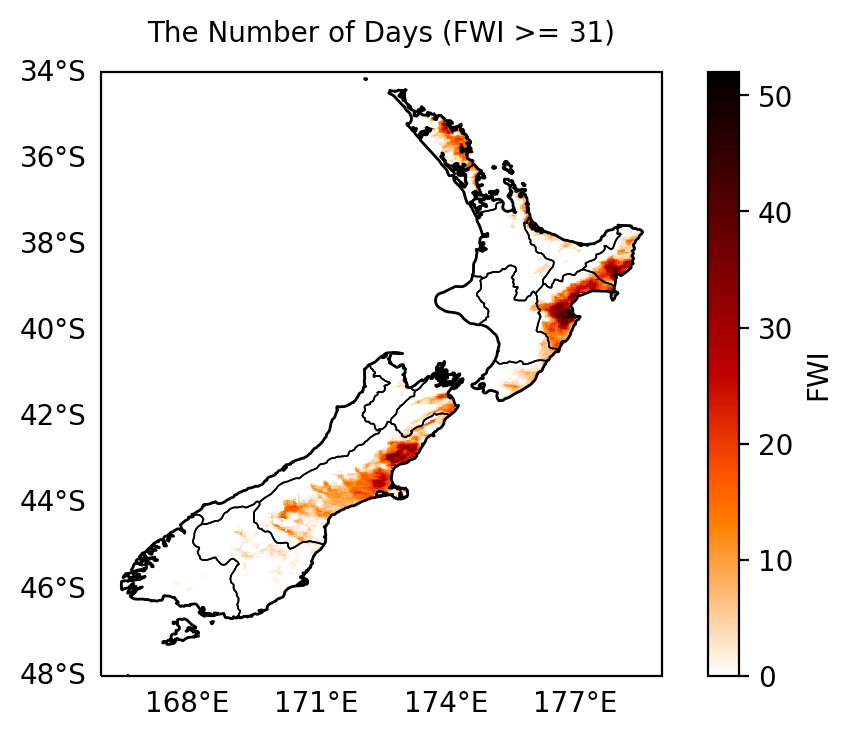

In [26]:
plot_fwi_map(data = fwi_binary_sum, cmap = "gist_heat_r")

#### Conclusion:
Regions with Highest Occurence of Extreme Fire Weather Conditions, ranked from highest, are:
1. Near the coastline of Hawke's Bay Region
2. On the south of Gisborne Region
3. On the west of Canterbury Region
4. On the west of Northland Region


### b. Exploration in Christchurch, Napier, Greymouth

#### Conclusion:
The plots for different cities show variations in the number of days with FWI (Fire Weather Index) values greater than or equal to 17. Each city plot has a different scale to accommodate the range of values. Notably, the plot for Christchurch possesses the largest scale, ranging from 0 to 2500. This discrepancy arises due to the inclusion of larger areas and the selection of a greater number of pixels for analysis when calculating the FWI values for Christchurch.

In Christchurch, observations results are:
1. From September to December throughout the years, the number of days with FWI >= 17 was no shifting as observed. The number of days fluctuated ramdomly during this period. 
2. From January to Feburary throughout the years, There is a slight increase in the the number of such days from 2000 to 2020. 
3. For the month of March, there is a decreasing trend observed from 2000 to 2020.

In Napier, the pattern can be observed:
1. From September to Feburary throughout the years, the number of days with FWI >= 17 was no shifting as observed. The number also fluctuated ramdomly.
2. For the month of March, it shows a slgiht decreasing trend from year 2000 to year 2020.

In Greymouth, there isn't a shift in the occurrence of extreme fire weather conditions. 
The number of days with FWI >= 17 remains relatively consistent over the years, with the value mostly at 0. There are occasional random peaks in January and March, but no significant shift can be observed.

#### The areas selected for analysis - Christchurch, Napier, Greymouth

In [183]:
import folium
from folium.plugins import MarkerCluster

# Create a folium map centered around New Zealand
nz_map = folium.Map(location=[-41.5, 172.834], zoom_start=6, control_scale=True)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(nz_map)

# Define the marker icons
icon_chch = folium.Icon(color='red', icon='info-sign')
icon_napier = folium.Icon(color='green', icon='info-sign')
icon_greymouth = folium.Icon(color='blue', icon='info-sign')

# Add markers to the marker cluster with customized icons and popups
marker1 = folium.Marker([-43.50, 172.5], popup='Christchurch', icon=icon_chch)
marker2 = folium.Marker([-39.4, 176.87], popup='Napier', icon=icon_napier)
marker3 = folium.Marker([-42.4, 171.2], popup='Greymouth', icon=icon_greymouth)
marker_cluster.add_child(marker1)
marker_cluster.add_child(marker2)
marker_cluster.add_child(marker3)

# Define the latitude and longitude ranges for Christchurch
lat_range_chch = (-43.626, -43.4028)
lon_range_chch = (172.383, 172.816)

# Create a rectangle overlay on the map using the defined range for Christchurch
rectangle_chch = folium.Rectangle(
    bounds=[(lat_range_chch[0], lon_range_chch[0]), (lat_range_chch[1], lon_range_chch[1])],
    color='red',
    fill=False,
    weight=2,
    opacity=0.7
)

# Define the latitude and longitude ranges for Napier
lat_range_napier = (-39.571, -39.385)
lon_range_napier = (176.80, 176.93)

# Create a rectangle overlay on the map using the defined range for Napier
rectangle_napier = folium.Rectangle(
    bounds=[(lat_range_napier[0], lon_range_napier[0]), (lat_range_napier[1], lon_range_napier[1])],
    color='green',
    fill=False,
    weight=2,
    opacity=0.7
)

# Define the latitude and longitude ranges for Greymouth
lat_range_greymouth = (-42.564, -42.371)
lon_range_greymouth = (171.129, 171.266)

# Create a rectangle overlay on the map using the defined range for Greymouth
rectangle_greymouth = folium.Rectangle(
    bounds=[(lat_range_greymouth[0], lon_range_greymouth[0]), (lat_range_greymouth[1], lon_range_greymouth[1])],
    color='blue',
    fill=False,
    weight=2,
    opacity=0.7
)

# Add the rectangle overlays to the map
rectangle_chch.add_to(nz_map)
rectangle_napier.add_to(nz_map)
rectangle_greymouth.add_to(nz_map)

# Customize the map tiles
folium.TileLayer('openstreetmap').add_to(nz_map)
folium.TileLayer('Stamen Terrain').add_to(nz_map)
folium.TileLayer('Stamen Toner').add_to

# Display the map
nz_map


#### Calculate the number of days (FWI >= 17)

In [139]:
def fwi_file_load(month, lon_range, lat_range):
    # Load FWI dataset in UTC timezone
    files_UTC = xr.open_mfdataset(f"/mnt/data/FWI_WRF/FWI*")
    
    # Convert the time coordinate to NZST timezone
    files = UTC_2_NZST(files_UTC)
    
    # Create an empty dictionary to store the result
    result_dict = {}
    
    # Select the specific month and locations
    for year in range(2000, 2021):
        # Filter the files based on month, longitude, and latitude
        selected_file = files.sel(time=files["time.month"] == month, lon=slice(*lon_range), lat=slice(*lat_range))
        # Further filter the selected files based on the year
        selected_file = selected_file.sel(time=selected_file["time.year"] == year).FWI
        
        with ProgressBar():
            # Load the selected file into memory for computation
            selected_file = selected_file.compute()
        
        # Create a binary representation of FWI values
        fwi_binary = selected_file.where(selected_file <= 17, 1).where(selected_file > 17, 0)
        # Calculate the sum of binary values along the "time" dimension
        fwi_binary_sum = fwi_binary.where(fwi_binary == 1).sum(dim="time").sum()
        
        # Store the sum in the result dictionary with the year as the key
        result_dict[year] = fwi_binary_sum
        # Print the year to track progress
        print(year)
    
    # Return the result dictionary
    return result_dict

In [28]:
chch_9 = fwi_file_load(month = 9, lat_range = (-43.626, -43.4028), lon_range = (172.383, 172.816))
chch_10 = fwi_file_load(month = 10, lat_range = (-43.626, -43.4028), lon_range = (172.383, 172.816))
chch_11 = fwi_file_load(month = 11, lat_range = (-43.626, -43.4028), lon_range = (172.383, 172.816))
chch_12 = fwi_file_load(month = 12, lat_range = (-43.626, -43.4028), lon_range = (172.383, 172.816))
chch_1 = fwi_file_load(month = 1, lat_range = (-43.626, -43.4028), lon_range = (172.383, 172.816))
chch_2 = fwi_file_load(month = 2, lat_range = (-43.626, -43.4028), lon_range = (172.383, 172.816))
chch_3 = fwi_file_load(month = 3, lat_range = (-43.626, -43.4028), lon_range = (172.383, 172.816))

[########################################] | 100% Completed |  5.0s
2000
[########################################] | 100% Completed |  5.4s
2001
[########################################] | 100% Completed |  5.1s
2002
[########################################] | 100% Completed |  5.7s
2003
[########################################] | 100% Completed |  6.6s
2004
[########################################] | 100% Completed |  5.4s
2005
[########################################] | 100% Completed |  5.1s
2006
[########################################] | 100% Completed |  6.2s
2007
[########################################] | 100% Completed |  5.5s
2008
[########################################] | 100% Completed |  6.1s
2009
[########################################] | 100% Completed |  6.2s
2010
[########################################] | 100% Completed |  6.4s
2011
[########################################] | 100% Completed |  6.4s
2012
[########################################] | 100% C

In [29]:
napier_9 = fwi_file_load(month = 9, lat_range =(-39.571, -39.385), lon_range = (176.80, 176.935))
napier_10 = fwi_file_load(month = 10, lat_range =(-39.571, -39.385), lon_range = (176.80, 176.935))
napier_11 = fwi_file_load(month = 11, lat_range =(-39.571, -39.385), lon_range = (176.80, 176.935))
napier_12 = fwi_file_load(month = 12, lat_range =(-39.571, -39.385), lon_range = (176.80, 176.935))
napier_1 = fwi_file_load(month = 1, lat_range =(-39.571, -39.385), lon_range = (176.80, 176.935))
napier_2 = fwi_file_load(month = 2, lat_range =(-39.571, -39.385), lon_range = (176.80, 176.935))
napier_3 = fwi_file_load(month = 3, lat_range =(-39.571, -39.385), lon_range = (176.80, 176.935))

[########################################] | 100% Completed |  0.2s
2000
[########################################] | 100% Completed |  0.2s
2001
[########################################] | 100% Completed |  0.2s
2002
[########################################] | 100% Completed |  0.2s
2003
[########################################] | 100% Completed |  0.2s
2004
[########################################] | 100% Completed |  0.2s
2005
[########################################] | 100% Completed |  0.2s
2006
[########################################] | 100% Completed |  0.2s
2007
[########################################] | 100% Completed |  0.2s
2008
[########################################] | 100% Completed |  0.2s
2009
[########################################] | 100% Completed |  0.2s
2010
[########################################] | 100% Completed |  0.2s
2011
[########################################] | 100% Completed |  0.2s
2012
[########################################] | 100% C

In [30]:
greymouth_9 = fwi_file_load(month = 9, lat_range = (-42.564, -42.371), lon_range = (171.129, 171.266))
greymouth_10 = fwi_file_load(month = 10, lat_range = (-42.564, -42.371), lon_range = (171.129, 171.266))
greymouth_11 = fwi_file_load(month = 11, lat_range = (-42.564, -42.371), lon_range = (171.129, 171.266))
greymouth_12 = fwi_file_load(month = 12, lat_range = (-42.564, -42.371), lon_range = (171.129, 171.266))
greymouth_1 = fwi_file_load(month = 1, lat_range = (-42.564, -42.371), lon_range = (171.129, 171.266))
greymouth_2 = fwi_file_load(month = 2, lat_range = (-42.564, -42.371), lon_range = (171.129, 171.266))
greymouth_3 = fwi_file_load(month = 3, lat_range = (-42.564, -42.371), lon_range = (171.129, 171.266))

[########################################] | 100% Completed |  0.2s
2000
[########################################] | 100% Completed |  0.2s
2001
[########################################] | 100% Completed |  0.2s
2002
[########################################] | 100% Completed |  0.2s
2003
[########################################] | 100% Completed |  0.2s
2004
[########################################] | 100% Completed |  0.2s
2005
[########################################] | 100% Completed |  0.2s
2006
[########################################] | 100% Completed |  0.2s
2007
[########################################] | 100% Completed |  0.2s
2008
[########################################] | 100% Completed |  0.2s
2009
[########################################] | 100% Completed |  0.2s
2010
[########################################] | 100% Completed |  0.2s
2011
[########################################] | 100% Completed |  0.2s
2012
[########################################] | 100% C

#### Timeseries Plots

In [31]:
import matplotlib.pyplot as plt

def plot_for_each_month(month, chch_data, napier_data, greymouth_data):
    years = [int(year) for year in chch_data.keys()] 
    values1 = list(chch_data.values())
    values2 = list(napier_data.values())
    values3 = list(greymouth_data.values())
    
    # Create a figure and set its size
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot the data for CHCH on the first subplot
    axs[0].plot(years, values1, color='blue')
    axs[0].set_title('CHCH')
    axs[0].set_ylim(0, 2500) # Set y-axis limits for CHCH subplot
    
    # Plot the data for Napier on the second subplot
    axs[1].plot(years, values2, color='green')
    axs[1].set_title('Napier')
    axs[1].set_ylim(0, 750) # Set y-axis limits for Napier subplot
    
    # Plot the data for Greymouth on the third subplot
    axs[2].plot(years, values3, color='red')
    axs[2].set_title('Greymouth')
    axs[2].set_ylim(0, 14) # Set y-axis limits for Greymouth subplot
    
    months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    month_name = months[month]
    
    # Set the overall title for the figure
    fig.suptitle(f'The Number of Days for Three Cities (FWI >= 17) --- {month_name}', fontsize=19)
    
    # Add a legend to the plot
    axs[0].legend(['CHCH'])
    axs[1].legend(['Napier'])
    axs[2].legend(['Greymouth'])
    
    # Show the plot
    plt.show()

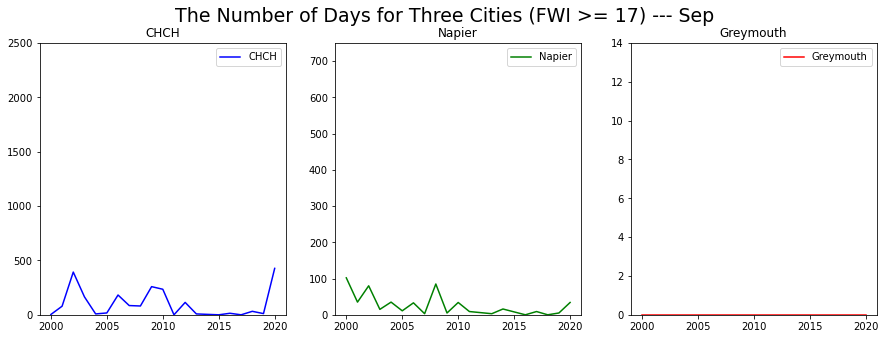

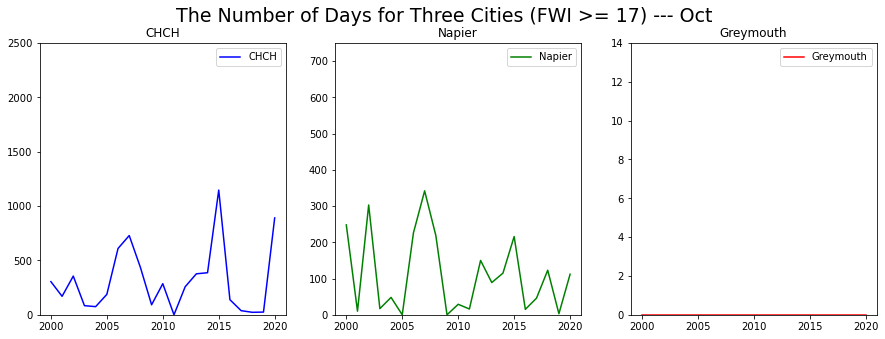

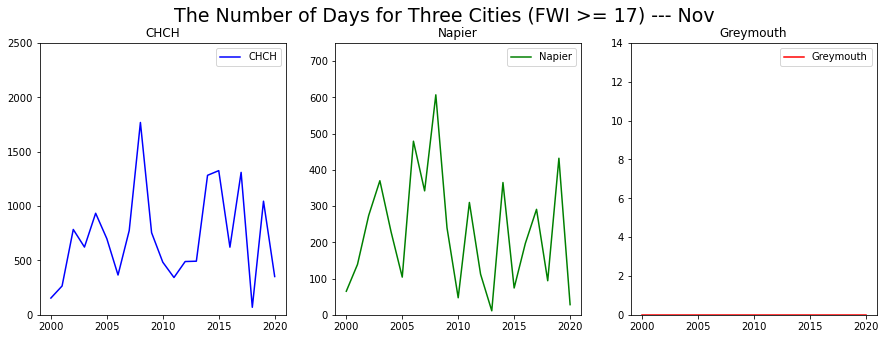

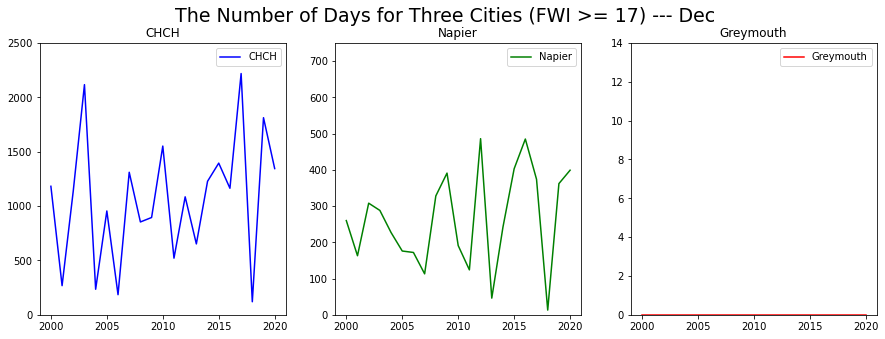

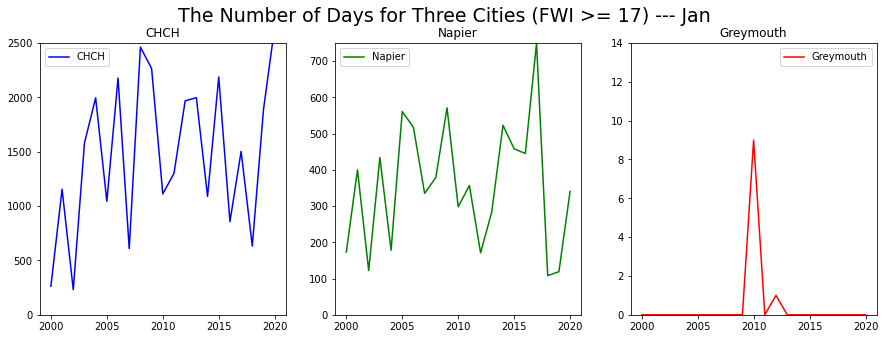

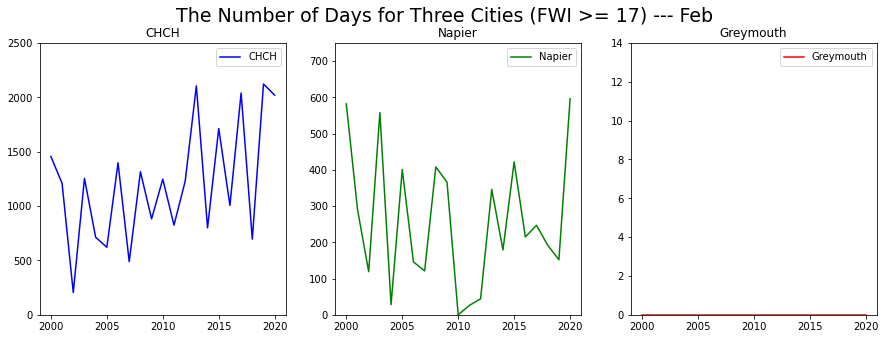

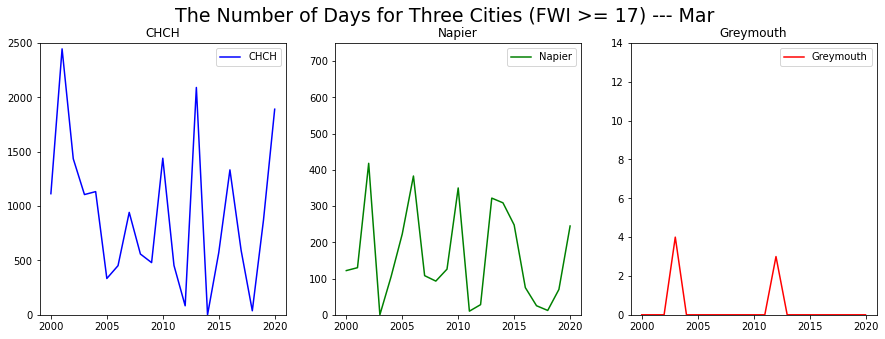

In [32]:
plot_for_each_month(9, chch_9, napier_9, greymouth_9)
plot_for_each_month(10, chch_10, napier_10, greymouth_10)
plot_for_each_month(11, chch_11, napier_11, greymouth_11)
plot_for_each_month(12, chch_12, napier_12, greymouth_12)
plot_for_each_month(1, chch_1, napier_1, greymouth_1)
plot_for_each_month(2, chch_2, napier_2, greymouth_2)
plot_for_each_month(3, chch_3, napier_3, greymouth_3)


If there is a requirement to analyze data for three cities on a shared plot, the following code has been made available for this purpose.

In [37]:
import matplotlib.pyplot as plt

def plot_one_for_each_month(month, chch_data, napier_data, greymouth_data):
    years = [int(year) for year in chch_data.keys()] 
    values1 = list(chch_data.values())
    values2 = list(napier_data.values())
    values3 = list(greymouth_data.values())
    
    # Create a figure and set its size
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot the data for CHCH
    ax.plot(years, values1, color='blue', label='CHCH')
    
    # Plot the data for Napier
    ax.plot(years, values2, color='green', label='Napier')
    
    # Plot the data for Greymouth
    ax.plot(years, values3, color='red', label='Greymouth')
    
    # Set y-axis limits
    ax.set_ylim(0, 2500)  # Adjust the limit based on your data
    
    # Set x-axis label and tick labels
    ax.set_xlabel('Years')
    ax.set_xticks(years)
    ax.set_xticklabels(years)
    
    months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    month_name = months[month]
    
    # Set the title for the plot
    ax.set_title(f'The Number of Days for Three Cities (FWI >= 17) --- {month_name}', fontsize=19)
    
    # Add a legend to the plot
    ax.legend()
    
    # Show the plot
    plt.show()


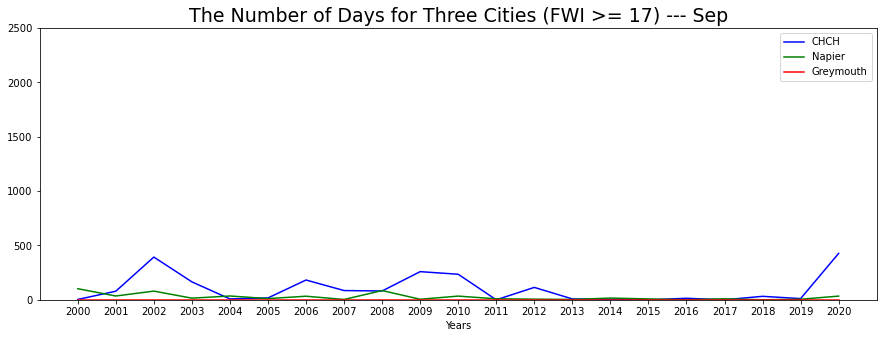

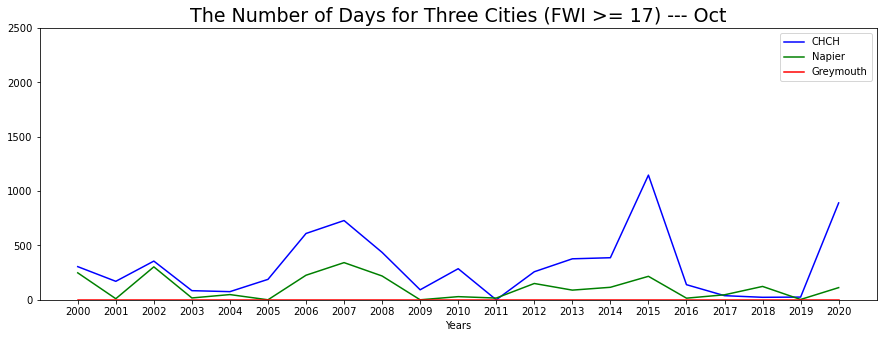

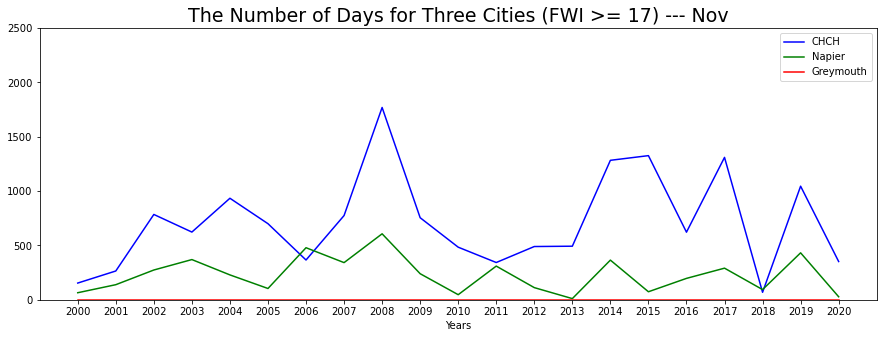

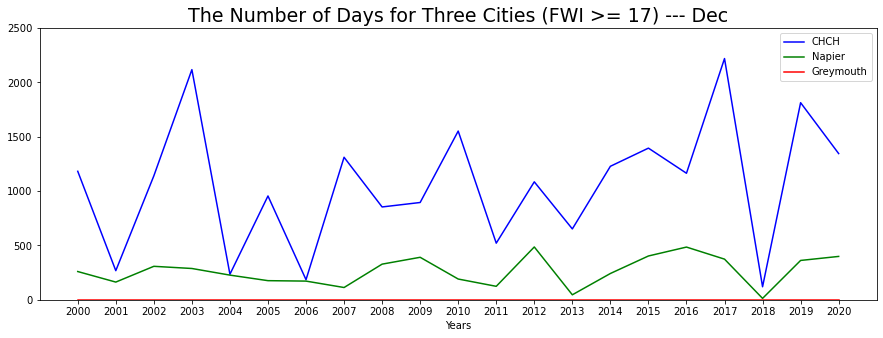

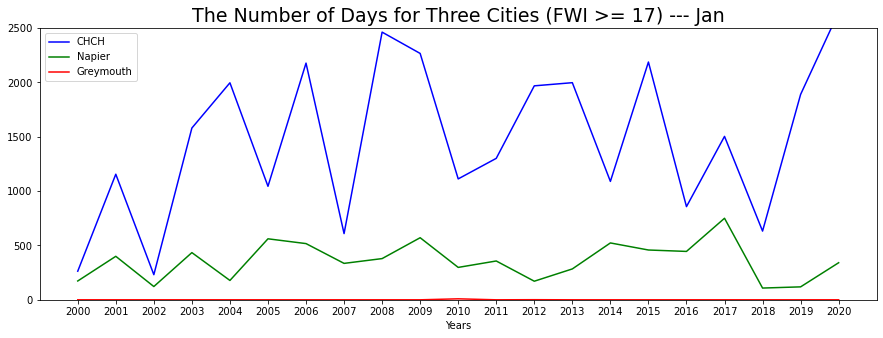

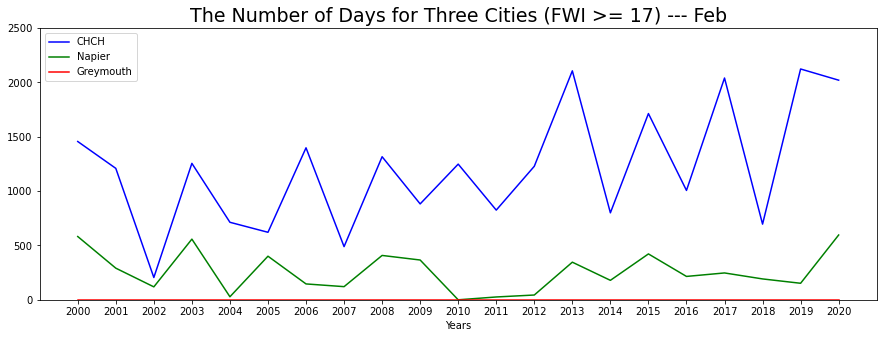

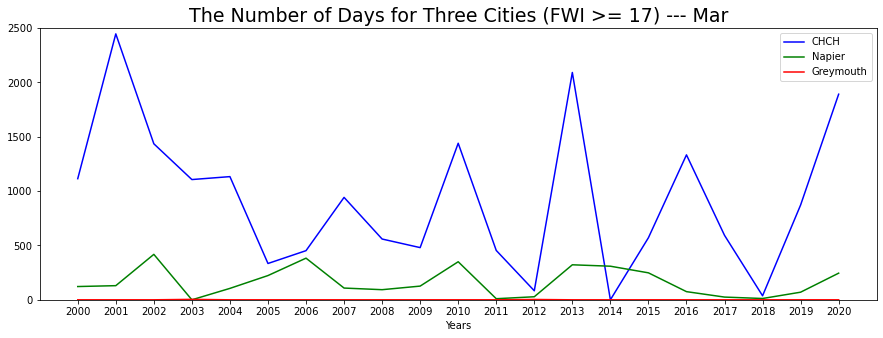

In [38]:
plot_one_for_each_month(9, chch_9, napier_9, greymouth_9)
plot_one_for_each_month(10, chch_10, napier_10, greymouth_10)
plot_one_for_each_month(11, chch_11, napier_11, greymouth_11)
plot_one_for_each_month(12, chch_12, napier_12, greymouth_12)
plot_one_for_each_month(1, chch_1, napier_1, greymouth_1)
plot_one_for_each_month(2, chch_2, napier_2, greymouth_2)
plot_one_for_each_month(3, chch_3, napier_3, greymouth_3)